In [3]:
%matplotlib widget
import matplotlib
from config.config import get_cfg_defaults
import torch
import torchvision
from torchvision.utils import make_grid
from torch.optim import AdamW
import torch
from denoising_diffusion_pytorch import Unet, GaussianDiffusion
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.animation import FuncAnimation
import matplotlib.colors as colors
plt.rcParams['text.usetex'] = True

In [32]:
# utility function that visualize the sampling process via a video
def save_sampling_video(sample, path, time):
    # todo: we need to keep the total number of frames fixed
    def update_colorbar_limits_and_cmap(fig, surface, z):
        cbar.mappable.set_clim(vmin=np.min(z), vmax=np.max(z))
        cbar.update_normal(surface)

    def set_camera_angle(ax, elev, azim):
        ax.view_init(elev=elev, azim=azim)
    
    def elevation_map(t):
        return sample[t]
    
    def update(t):
        ax.clear()
        if t < time:
            z = elevation_map(t)
        else:
            z = elevation_map(time-1)
            
        surface = ax.plot_surface(x, y, z, cmap='terrain', linewidth=1, antialiased=False)
        azim = -np.pi + t * dtheta
        set_camera_angle(ax, elev=45, azim=np.degrees(azim))
        return surface,

    T, C, H, W = sample.shape
    dtheta = 2 * np.pi / T
    resolution = 0.1
    x = np.arange(0, H*resolution, resolution)
    y = np.arange(0, W*resolution, resolution)
    x, y = np.meshgrid(x, y)
    sample = torch.squeeze(sample).to('cpu').detach().numpy()


    fig = plt.figure()
    ax = fig.gca(projection='3d')
    set_camera_angle(ax, elev=45, azim=-90)
    surf = ax.plot_surface(x, y, sample[0], cmap='terrain', linewidth=1, antialiased=False)
    # Add a colorbar to represent the elevation values
    cbar = fig.colorbar(surf, shrink=0.5, aspect=5)
    update_colorbar_limits_and_cmap(fig, surf, sample)
    # Set labels for axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Elevation')
    # Show the plot
    anim = FuncAnimation(fig, update, frames=np.arange(0, time+100), interval=30, blit=True)

    # Save as mp4 (requires ffmpeg)
    anim.save(path, writer='ffmpeg')
    plt.show()

# utility function that visualizes the elevation map in 3D
def visualize_elevation_map(last_samples, n_rows=2, n_cols=3, subtitles=None):
    # we choose the first six samples to show
    num_viz = 6
    vis_samples = last_samples[:num_viz].squeeze().to('cpu').detach().numpy()
    
    B, C, H, W = last_samples.shape
    resolution = 0.1
    x = np.arange(0, H*resolution, resolution)
    y = np.arange(0, W*resolution, resolution)
    x, y = np.meshgrid(x, y)
    
    fig = plt.figure(figsize=(10, 6))
    
    # Normalize the colormap
    norm = colors.Normalize(vmin=np.min(vis_samples), vmax=np.max(vis_samples))
    # Create a ScalarMappable with the desired colormap
    sm = plt.cm.ScalarMappable(cmap='terrain', norm=norm)
    sm.set_array([])  # Important: This line is required to make the colorbar work

    for i in range(n_rows):
        for j in range(n_cols):
            index = i*n_cols+j
            ax = fig.add_subplot(n_rows, n_cols, index+1, projection='3d')
            if subtitles != None:
                ax.set_title(subtitles[index])
            ax.view_init(elev=45, azim=-45)
            surf = ax.plot_surface(x, y, vis_samples[index], cmap='terrain', linewidth=1, antialiased=False)
    # Create the colorbar outside the plot
    cbar_ax = fig.add_axes([0.9, 0.15, 0.03, 0.7])
    fig.colorbar(sm, cax=cbar_ax)
    plt.subplots_adjust(left=0, top=0.95, wspace=0.1, hspace=0.1, right=0.9)
    plt.show()

In [22]:
# load the model
model = Unet(
    dim = 16,
    channels = 1,
    dim_mults = (1, 2, 4)
).cuda()

diffusion = GaussianDiffusion(
    model,
    image_size = 128,
    timesteps = 1000,           # number of steps
    sampling_timesteps = 250,   # number of sampling timesteps (using ddim for faster inference [see citation for ddim paper])
).cuda()

state_dict = torch.load('trained_models/model-55.pt')['model']
diffusion.load_state_dict(state_dict)

<All keys matched successfully>

In [23]:
shape = (16, 1, 128, 128)
p_samples = diffusion.ddim_sample(shape, True)

sampling loop time step:   0%|          | 0/250 [00:00<?, ?it/s]

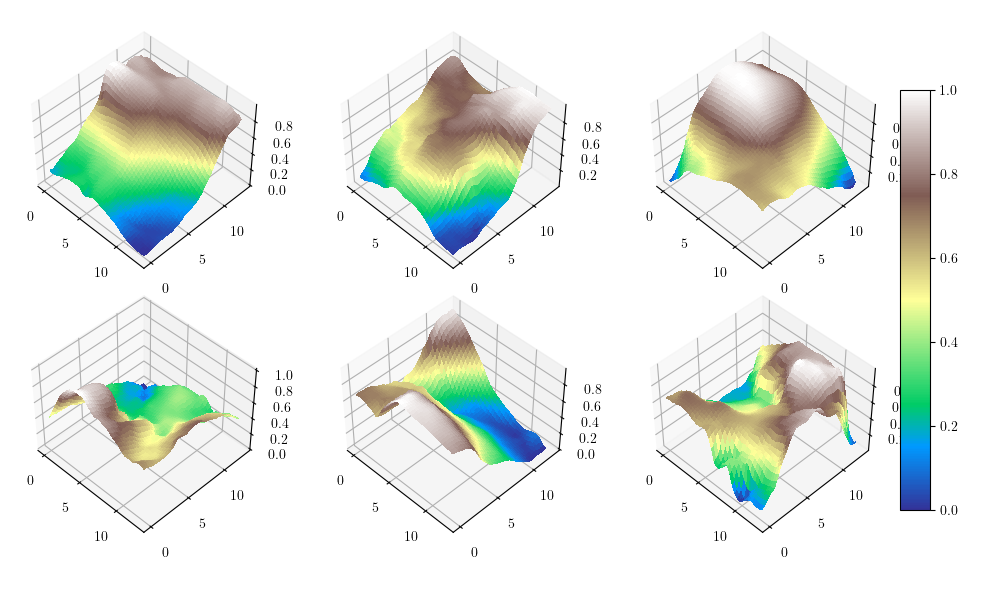

In [24]:
visualize_elevation_map(p_samples[:6, -1])

/tmp/ipykernel_80810/3095951705.py:36: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


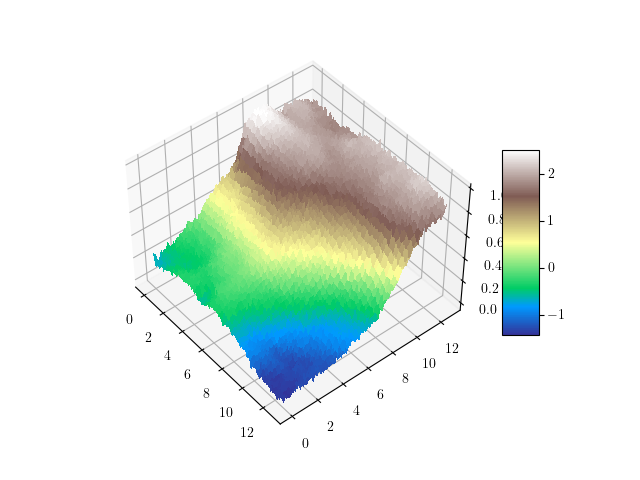

In [34]:
save_sampling_video(p_samples[0, :], 'original.mp4', 250)

In [37]:
p_samples = diffusion.p_sample_loop(shape, True)

sampling loop time step:   0%|          | 0/1000 [00:00<?, ?it/s]

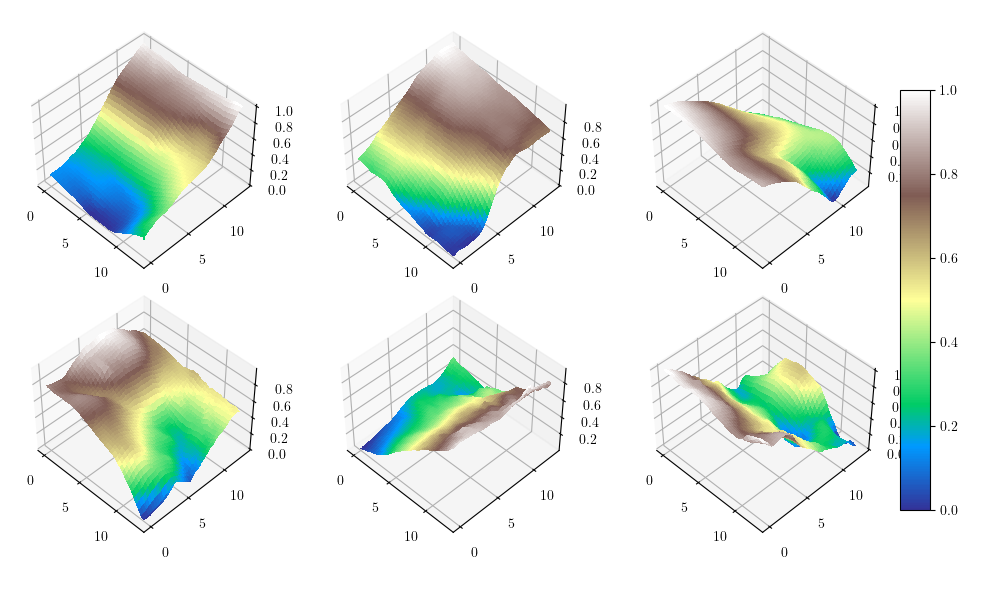

In [38]:
visualize_elevation_map(p_samples[:6, -1])

/tmp/ipykernel_80810/3095951705.py:36: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection='3d')


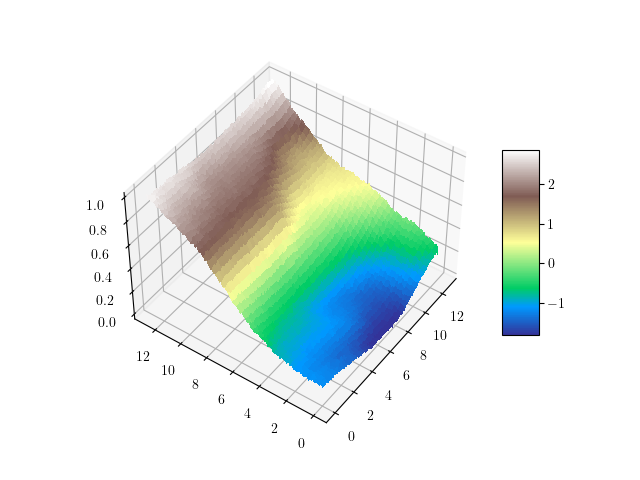

In [39]:
save_sampling_video(p_samples[0, :], 'ddpm.mp4', 1000)